In [1]:
from python_graphql_client import GraphqlClient
import json
import networkx as nx
import matplotlib.pyplot as plt

In [69]:
endpoint = 'https://api2.mapofzones.com/v1/graphql'

# Instantiate the client with an endpoint.
client = GraphqlClient(endpoint=endpoint)

# Create the query string and variables required for the request.
query = """
    query ZoneName($zone: String!) {
        blockchain: flat_blockchains(where: {network_id: {_eq: $zone}}) {
            name
            __typename
        }
    }
"""

variables = {"zone":"stride-1"}

# Synchronous request
data = client.execute(query=query, variables=variables)
print(data) 

{'data': {'blockchain': [{'name': 'Stride', '__typename': 'flat_blockchains'}]}}


In [34]:
query = """
query AseetsTable {
  assets: flat_tokens {
    blockchain: blockchainByBlockchain {
      name
      __typename
    }
    symbol
    logoUrl: logo_url
    price
    price24hDiffPercent: price_day_diff_percent
    price7dDiffPercent: price_week_diff_percent
    marketCap: market_cap
    volume24h: token_day_trading_volume
    volume24hDiffPercent: token_day_trading_volume_diff_percent
    onChainSupply: on_chain_supply
    priceChart: token_charts(
      where: {chart_type: {_eq: "price_weekly"}}
      order_by: {point_index: asc}
    ) {
      price: point_value
      __typename
    }
    __typename
  }
}
"""

variables = {}

data = client.execute(query=query, variables=variables)
with open('data/marketcap.json', 'w') as f:
    json.dump(data, f)

In [32]:
query = """
query ZonesMap($period: Int!, $isMainnet: Boolean!) {
  zonesStats: flat_blockchains(where: {is_mainnet: {_eq: $isMainnet}}) {
    ...ZoneBaseInfoV2
    isMainnet: is_mainnet
    switchedStats: blockchain_switched_stats(
      where: {timeframe: {_eq: $period}, is_mainnet: {_eq: $isMainnet}}
    ) {
      ibcVolume: ibc_cashflow
      ibcVolumeIn: ibc_cashflow_in
      ibcVolumeOut: ibc_cashflow_out
      ibcVolumeRating: ibc_cashflow_rating
      ibcTransfersRating: ibc_transfers_rating
      dauRating: active_addresses_cnt_rating
      totalTxsRating: txs_rating
      __typename
    }
    __typename
  }
  zonesGraphs: flat_blockchain_relations(
    where: {blockchain: {is_mainnet: {_eq: $isMainnet}}, blockchainByBlockchainSource: {is_mainnet: {_eq: $isMainnet}}, timeframe: {_eq: $period}}
  ) {
    source: blockchain_source
    target: blockchain_target
    ibcVolume: ibc_cashflow
    __typename
  }
}

fragment ZoneBaseInfoV2 on flat_blockchains {
  zone: network_id
  logoUrl: logo_url
  name: name
  __typename
}
"""

variables = {"period": 24, "isMainnet": True}
data = client.execute(query=query, variables=variables)
with open('data/zonemap.json', 'w') as f:
    json.dump(data, f)

In [60]:
mapdata = dict()

with open('data/zonemap.json', 'r') as f:
    mapdata = json.load(f)

zones = mapdata['data']['zonesStats']
zones_map = {zone['zone']: zone['name'] for zone in zones}
channels = mapdata['data']['zonesGraphs']

In [71]:
query = """
query ZonesListZonePeers($source: String!, $period: Int!, $isMainnet: Boolean!) {
  zones: flat_blockchains(
    where: {is_mainnet: {_eq: $isMainnet}, network_id: {_neq: $source}, channelsStatsByCounterpartyBlockchain: {blockchain: {_eq: $source}}}
  ) {
    data: channelsStatsByCounterpartyBlockchain_aggregate(
      where: {blockchain: {_eq: $source}, timeframe: {_eq: $period}}
    ) {
      aggregate {
        sum {
          ibcTransfers: ibc_transfers
          ibcTransfersPending: ibc_transfers_pending
          ibcTransfersFailed: ibc_transfers_failed
          ibcVolume: ibc_cashflow
          ibcVolumePending: ibc_cashflow_pending
          ibcVolumeIn: ibc_cashflow_in
          ibcVolumeInPending: ibc_cashflow_in_pending
          ibcVolumeOut: ibc_cashflow_out
          ibcVolumeOutPending: ibc_cashflow_out_pending
          __typename
        }
        __typename
      }
      zoneChannels: nodes {
        zoneCounterparty: blockchainByCounterpartyBlockchain {
          zone: network_id
          name
          logoUrl: logo_url
          isUpToDate: is_synced
          __typename
        }
        zone: blockchain
        zoneCounterpartyChannelId: counterparty_channel_id
        channelId: channel_id
        clientId: client_id
        connectionId: connection_id
        isOpened: is_channel_open
        ibcTransfers: ibc_transfers
        ibcTransfersPending: ibc_transfers_pending
        ibcTransfersFailed: ibc_transfers_failed
        ibcTransfersSuccessRate: ibc_transfers_success_rate
        ibcVolume: ibc_cashflow
        ibcVolumePending: ibc_cashflow_pending
        ibcVolumeIn: ibc_cashflow_in
        ibcVolumeInPending: ibc_cashflow_in_pending
        ibcVolumeOut: ibc_cashflow_out
        ibcVolumeOutPending: ibc_cashflow_out_pending
        __typename
      }
      __typename
    }
    __typename
  }
}
"""

for zone in zones:
  variables = {
    "source": zone['zone'],
    "period": 24,
    "isMainnet": True
  }
  data = client.execute(query=query, variables=variables)
  with open('data/peers/%s.json' % zone['zone'], 'w') as f:
    json.dump(data, f)

In [ ]:
marketdata_raw = dict()
with open('data/marketcap.json', 'r') as f:
    marketdata_raw = json.load(f)

marketdata = dict()
for asset in marketdata_raw['data']['assets']:
    marketdata[asset['blockchain']['name']] = asset['marketCap']

marketdata

In [4]:


G = nx.Graph()
for zone in zones:
    if zone['name'] in marketdata and marketdata[zone['name']] != None:
        market_cap = int(marketdata[zone['name']])
        G.add_node(zone['zone'], weight=market_cap)

for chan in channels:
    if chan["ibcVolume"] == 0:
        continue
    if chan["source"] not in G.nodes:
        continue
    if chan['target'] not in G.nodes:
        continue
    G.add_edge(chan["source"], chan["target"], weight=chan["ibcVolume"])

G


In [5]:
total_cap = 0

for node in G.nodes():
    total_cap += G.nodes[node]['weight']
print(total_cap)

9270854959


In [6]:
def aggregate_node_weights(G, path):
    """
    Calculate sum of the weights in a path.
    """
    return sum(G.nodes[node]['weight'] for node in path)

def find_heaviest_path(G, source, target):
    """
    Find the heaviest path between source and target nodes.
    """
    max_path = []
    max_weight = 0
    for path in nx.all_simple_paths(G, source, target):
        weight = aggregate_node_weights(G, path)
        if weight > max_weight:
            max_path = path
            max_weight = weight
    return max_path, max_weight

import itertools

def find_heaviest_path_all(G):
    max_path = []
    max_weight = 0
    nodes = list(G.nodes)
    combinations = list(itertools.combinations(nodes, 2))
    print(combinations)
    for combination in combinations:
        source = combination[0]
        target = combination[1]
        print(source, target, end=' ')
        max_path1, max_weight1 = find_heaviest_path(G, source, target)
        print(max_path1, max_weight1)
        if max_weight1 > max_weight:
            max_path = max_path1
            max_weight = max_weight1


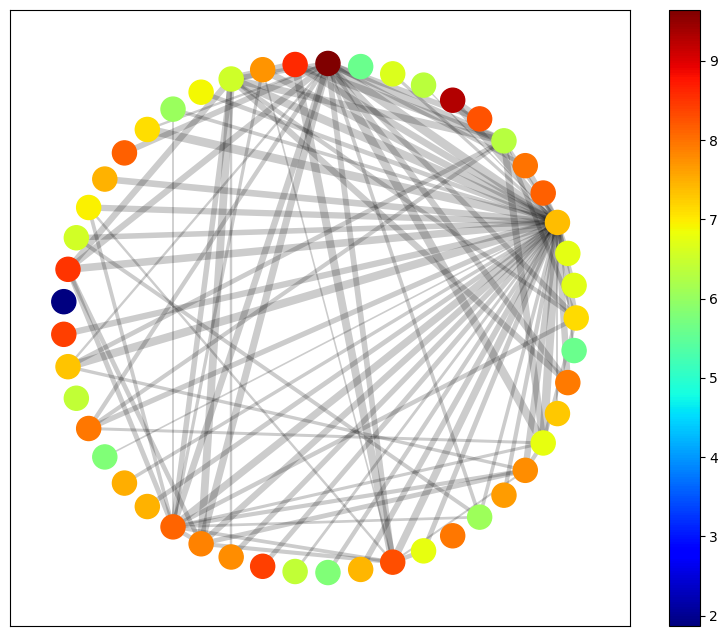

In [67]:
import math
import numpy

node_labels = {node: zones_map[node] for node in G.nodes}
node_weights = [math.log10(G.nodes[node]['weight']) for node in G.nodes]
edge_weights = [math.log10(edge[2]) for edge in G.edges(data='weight')]

fig = plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)
ec = nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, node_labels, node_color=node_weights, cmap=plt.cm.jet)
# labels = nx.draw_networkx_labels(G,pos,node_labels,font_size=16,font_color='r')

plt.colorbar(nc)
plt.show()